In [24]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path):
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

#make visible only the zero GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import argparse
import hashlib
import itertools
import random
import json
import logging
import math
import os
from contextlib import nullcontext
from pathlib import Path
from typing import Optional

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDIMScheduler, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.utils.import_utils import is_xformers_available
from huggingface_hub import HfFolder, Repository, whoami
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from matplotlib import pyplot as plt

torch.backends.cudnn.benchmark = True

In [16]:
logger = get_logger(__name__)


class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        concepts_list,
        tokenizer,
        with_prior_preservation=True,
        size=512,
        center_crop=False,
        num_class_images=None,
        pad_tokens=False,
        hflip=False,
        read_prompts_from_txts=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer
        self.with_prior_preservation = with_prior_preservation
        self.pad_tokens = pad_tokens
        self.read_prompts_from_txts = read_prompts_from_txts

        self.instance_images_path = []
        self.class_images_path = []

        for concept in concepts_list:
            inst_img_path = [
                (x, concept["instance_prompt"])
                for x in Path(concept["instance_data_dir"]).iterdir()
                if x.is_file() and not str(x).endswith(".txt")
            ]
            self.instance_images_path.extend(inst_img_path)

            if with_prior_preservation:
                class_img_path = [(x, concept["class_prompt"]) for x in Path(concept["class_data_dir"]).iterdir() if x.is_file()]
                self.class_images_path.extend(class_img_path[:num_class_images])

        random.shuffle(self.instance_images_path)
        self.num_instance_images = len(self.instance_images_path)
        self.num_class_images = len(self.class_images_path)
        self._length = max(self.num_class_images, self.num_instance_images)

        self.image_transforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(0.5 * hflip),
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_path, instance_prompt = self.instance_images_path[index % self.num_instance_images]

        if self.read_prompts_from_txts:
            with open(str(instance_path) + ".txt") as f:
                instance_prompt = f.read().strip()

        instance_image = Image.open(instance_path)
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")

        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            instance_prompt,
            padding="max_length" if self.pad_tokens else "do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.with_prior_preservation:
            class_path, class_prompt = self.class_images_path[index % self.num_class_images]
            class_image = Image.open(class_path)
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                class_prompt,
                padding="max_length" if self.pad_tokens else "do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example


class PromptDataset(Dataset):
    "A simple dataset to prepare the prompts to generate class images on multiple GPUs."

    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example


class LatentsDataset(Dataset):
    def __init__(self, latents_cache, text_encoder_cache):
        self.latents_cache = latents_cache
        self.text_encoder_cache = text_encoder_cache

    def __len__(self):
        return len(self.latents_cache)

    def __getitem__(self, index):
        return self.latents_cache[index], self.text_encoder_cache[index]


class AverageMeter:
    def __init__(self, name=None):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = self.count = self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def get_full_repo_name(model_id: str, organization: Optional[str] = None, token: Optional[str] = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"



In [17]:
# HP
output_dir = str(repo_path / 'dreambooth/weights' / "stable_diffusion_weights/ukj")

seed = 1337
concepts_list="concepts_list.json"
mixed_precision = "fp16"
revision = 'fp16'
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
learning_rate = 1e-6
with_prior_preservation = True
resolution = 512
num_class_images  =12
train_batch_size = 1

In [18]:
logging_dir = Path(output_dir, "0",f"{output_dir}/runs/")

accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision=mixed_precision,
    log_with="tensorboard",
    logging_dir=logging_dir,
)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

# Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
# This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
# TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
if True and 1 > 1 and accelerator.num_processes > 1:
    raise ValueError(
        "Gradient accumulation is not supported when training the text encoder in distributed training. "
        "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
    )

if seed is not None:
    set_seed(seed)



with open(concepts_list, "r") as f:
    concepts_list = json.load(f)


tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    revision=revision,
)

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="text_encoder",
    revision=revision,
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="vae",
    revision=revision,
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="unet",
    revision=revision,
    torch_dtype=torch.float32
)

vae.requires_grad_(False)


/home/ricardo/miniconda3/envs/dreambooth/lib/python3.9/site-packages/accelerate/accelerator.py:243: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
/home/ricardo/miniconda3/envs/dreambooth/lib/python3.9/site-packages/accelerate/accelerator.py:353: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3,

In [19]:

if is_xformers_available():
    vae.enable_xformers_memory_efficient_attention()
    unet.enable_xformers_memory_efficient_attention()
else:
    logger.warning("xformers is not available. Make sure it is installed correctly")

# Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
if True:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit

params_to_optimize = (
    itertools.chain(unet.parameters(), text_encoder.parameters()) if True else unet.parameters()
)
optimizer = optimizer_class(
    params_to_optimize,
    # lr=learning_rate,
    # betas=(adam_beta1, adam_beta2),
    # weight_decay=adam_weight_decay,
    # eps=adam_epsilon,
)

noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

train_dataset = DreamBoothDataset(
    concepts_list=concepts_list,
    tokenizer=tokenizer,
    with_prior_preservation=with_prior_preservation,
    size=resolution,
    center_crop=False,
    num_class_images=num_class_images,
    pad_tokens=False,
    hflip=False,
    read_prompts_from_txts=False,
)

def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.
    if with_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids},
        padding=True,
        return_tensors="pt",
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True
)


In [26]:
# get next batch
batch = next(iter(train_dataloader))

03/17/2023 21:56:36 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


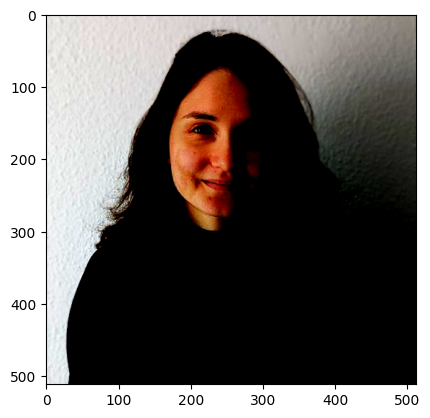

In [29]:
# show image
plt.imshow(batch['pixel_values'][0].permute(1,2,0).numpy(), cmap='gray')